In [3]:
import sys
from joblib import dump, load
sys.path.append("..")
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import imp
from pathlib import Path

from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg

import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *

import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
import common_vars as comv

import csv
import helpers
imp.reload(helpers)
imp.reload(comv)
imp.reload(pg)
from feature_extraction import pytorch_models as tm
imp.reload(tm)
from helpers import *

from common_vars import SR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pack_dir="mme_pack_r2"
classes= ['clap', 'hat', 'kick', 'snare', 'synth_noise']
# device = "cpu"


def model_loader(m,p):
    s=torch.load(p) 
    m.load_state_dict(s)
    m.to(device)
    return m

In [2]:
from IPython.display import Audio
import librosa.display

for g in classes:
    Path(pack_dir+"/"+g).mkdir(parents=True, exist_ok=True)
#round 1
# MME models 
#optimized params
learning_rate = 0.0011451089315356296
dropout_rate = 0.5
latent_size = 64
FREQ_BINS = 30
TIME_STEPS = 20
hidden_layers = 2
l2 = 3.2473701348597023e-06
clf = load('../feature_extraction/models/mme/mme_extra_trees.joblib') 
m = tm.AE_Conv(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,num_channels=5,eval_mode=True).to(device)
m = model_loader(m,"../feature_extraction/models/encode/nosynth_64_195_0.000450.pt")
spec_env_trns=tm.spec_and_env(tm.AE_specTrans(FREQ_BINS,time_steps=TIME_STEPS),tm.AE_envTrans(num_mels=10,SR=SR))


#round 2

In [102]:
import uuid

# %%time
#     with open("generations/pickles/%d.pkl"%j, 'wb') as pfile:
#         pickle.dump(params,pfile,-1)

#make mme pipeline
a,sr = librosa.load("../feature_extraction/drum_dbs/dk_data/kick/Acetone Rhythm Ace-MaxV - KICK1.wav")

def make_pack(iteration=0):
   
    stack_size=random.randint(1,5)
    out,params= stackMaker(stack_size)
    a= memToAud(out)
    try:
        a=librosa.util.normalize(a)
    except:
        pass

    s={"signal":torch.tensor(a,dtype=torch.float32),"label":"","path":"","drum_type":""}

    t = spec_env_trns(s) #we got the transformation
    spec_feat,env_feat=t["spec_trans_results"]["feats"],t["env_trans_results"] # env and spec transforms
    m(spec_feat.contiguous().view(-1,TIME_STEPS,FREQ_BINS).to(device))
    embeddings=list(m.encoding.detach().cpu().numpy()[0])
    env_feat=env_feat.cpu().numpy()
    embeddings.extend(env_feat)
    prediction = clf.predict([embeddings])[0]
    
    if prediction != 4:
        root_name="%s_%d.wav"%(uuid.uuid4().hex[0:5],stack_size)

        #write sound file and pickle params
        out.write("./%s/%s/%s"%(pack_dir,classes[prediction],root_name,))
        with open("pkls/"+"%s.pkl"%root_name, 'wb') as pfile:
            pickle.dump(params,pfile,-1)       
        #make row for predictions csv
        row=[root_name,stack_size,classes[prediction],iteration]
        print(f'{row}\r',end="")
        
        with open("model_predictions_r2.csv", "a", newline='') as fp:
            wr = csv.writer(fp, dialect='excel')
            wr.writerow(row)

for i in range(1000):
    make_pack(i)

NameError: name 'env_feats' is not defined

<Figure size 864x216 with 0 Axes>

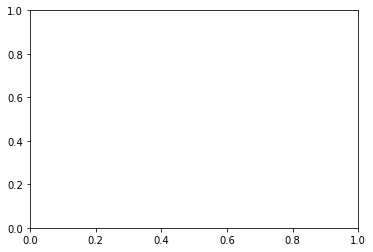

In [8]:
fig = plt.figure(figsize=(12,3))
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(1, 3,1)

plt.plot(env_feats.cpu())
ax = plt.subplot(1, 3,2)
plt.plot(freq_feats[0:50].cpu())
ax=plt.subplot(1,3,3)
ft=pitch_feats.cpu()
ft=ft.numpy()
librosa.display.specshow(ft[0])
Audio(a,rate=sr, autoplay=True)